# Defining Cavity Eigenmodes with the Cavity Command

When modelling higher order mode effects in optical cavities, you must decide which optical bases to use. This means you must choose which gaussian beam parameters ($q = w_0 + iz_r$) are used a each node in the model. Finesse will then model the transverse shape of the optical modes using the Hermite-Gaussian decomposition, with the $q$ value defining the shape of the beam at the node. Technically, any choice of $q$ should work, assuming you can use infinite HG modes. However, computationally this is not ideal, nor possible. What you must do is try to optimally choose which to use.

For a single cavity, the choice is clear, we should use the standard eigenmode calculation that is retrieved from the roundtrip ABCD matric calculations. This deinfes the $q$ calues used at all the intra-cavity nodes. Next, the beam tracing algorithm will take this cavity eigenmode and trace it to all other nodes in the model that have not been defined, ensuring every node has a $q$. If you change the cavity geometry, therefore the eigenmode, the beam trace will be repeated and all other nodes will follow.

## Coupled Cavities

Models become more complex with coupled cavities as we no longer have a well defined theoretical description of what the correct eigenmode should be. This is because there is no single roundtrip ABCD matrix that can be written and then solved.

In such cases, we can only aim to include enough higher order modes that we converge to a solution. The actual cavity eigenmode is then no longer purely described by the $q$ values in the coupled cavity, but a combination of *q* and a set of complex-values HG mode amplitudes in the $q$ basis.

In FINESSE we have the *cavity* command which allows you to quickly compute the simple cavity roundtrip eigenmodes. This command takes a start node and tries to find the simplest circular path in the model back to itself. You can also define a *via* node to guide it in more complicated models. For coupled cavities we have multiple ways in which we can use this command to help build our models. However, we must be careful on how we use it as demonstrated below.

Let us study a power-recycled Fabry-Perot. In particular, this is an aLIGO arm cavity and the power recycling cavity. This forms a simplified model of the common arm (CARM). Near the ITM we model any substrate thermal changes as with a simple lens object, which has a focal length.

In [1]:
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.init_plotting()

model = finesse.script.parse("""
###############################################################################
###   length definitions
###############################################################################
variable Larm 3994.47
variable LPR23 16.164  # distance between PR2 and PR3
variable LPR3BS 19.538 # distance between PR3 and BS
variable lmich 5.342   # average length of MICH
variable lschnupp 0.08
variable lPRC (3+0.5)*c0/(2*f1) # T1000298 Eq2.1, N=3

variable f1 9099471
variable f2 5*f1
variable nsilica 1.45
variable Mloss 0

laser L0 P=1
mod mod1 f=f1 midx=0.2
link(L0, mod1, PRM)
m PRM T=0.03 L=0 Rc=11.009 phi=0
s lp1 PRM.p2 PR2.p1 L=lPRC-LPR3BS-LPR23-lmich
bs PR2 T=250u L=Mloss alpha=-0.79 Rc=-4.545
s lp2 PR2.p2 PR3.p1 L=LPR23
bs PR3 T=0 L=Mloss alpha=0.615 Rc=36.027
s lp3 PR3.p2 BS.p1 L=LPR3BS

###############################################################################
###   BS
###############################################################################
bs BS R=1 L=0 alpha=45

###############################################################################
###   Yarm
###############################################################################
# Distance from beam splitter to Y arm input mirror
s ly1 BS.p2 ITMYlens.p1 L=lmich-lschnupp/2-ITMYsub.L*ITMYsub.nr
lens ITMYlens f=34000
s ly2 ITMYlens.p2 ITMYAR.p1
m ITMYAR R=0 L=20u
s ITMYsub ITMYAR.p2 ITMY.p1 L=0.2 nr=nsilica
m ITMY T=0.014 L=Mloss Rc=-1934
s LY ITMY.p2 ETMY.p1 L=Larm
m ETMY T=5u L=Mloss Rc=2245

pd Parm ETMY.p1.i
pd Prc PRM.p2.o
modes(even, maxtem=12)

ad pu9 PRM.p2.i f=+f1
ad pl9 PRM.p2.i f=-f1
mathd prc_cost log10(Parm/280)+log10(abs(pu9))+log10(abs(pl9))
""")

So far in this model, we have defined curvatures and lengths but not what $q$ values should be used. A common attempt now is to apply a cavity command to the arm mirrors. This can be done by adding the command below:

In [2]:
# make a copy so that we can add different cav commands
_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
# nodes that will be defined by the ITM and ETM geometry
print(_model.cavYARM.path.nodes_only)

[❮OpticalNode ETMY.p1.o @ 0x16c5d6500❯, ❮OpticalNode ITMY.p2.i @ 0x16c5d64a0❯, ❮OpticalNode ITMY.p2.o @ 0x16c5d6380❯, ❮OpticalNode ETMY.p1.i @ 0x16c5d4a60❯]


All other nodes, not in the arm cavity, will be traced from the closest node listed above.

This some has important consquences:
* If the power-recycling and arm cavities are perfectly mode-matched, then the arm mode traced around the power-recycling will be the ideal mode to use for both cavities.
* The input laser $q$ is not defined, it will in this case be dependnt on the arm cavity mode traced back to the laser. If you change the arm geometry so will the laser $q$, something that is not typically you will want to simulate.

## Mode-Mismatched Coupled Cavities

Perfectly matched cavities is not what we have in reality and is a typical case users want to model in FINESSE. Here are some suggestions for making better models. 

**Ensure that the laser $q$ is defined**. In realistic models, the laser mode is independent of the interferometer geometry. In gravitational wave detectors, the input mode is likely defined by the geometry of the input mode-cleaner cavity.

If you do not know the input mode, then another good option is to calculate the mode that perfectly matches some state you are interest in. In FINESSE 3.0 we can use some optimiser to maximise the arm powers.

In [3]:
_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
# Maximize the arm power with respect to the PRM curvature and ITMY lens
# There are multiple optimisations that could be done here, depends on what
# parameters you want to vary. This model is naturally astigmatic though due
# to the off-axis telescope.
opt_sol = _model.run("maximize(Parm, [ITMYlens.f, PRM.Rcx, PRM.Rcy, PRM.phi, ETMY.phi])")
print("HOMs Parm =       ", _model.run()['Parm'])
_model.modes("off")
print("Plane-wave Parm = ", _model.run()['Parm'])

# the plane-wave and HOM powers should be nearly identical, a sign that there
# is no mode-mismatch. If so, we then update the original model to use these
# new values
model.ITMYlens.f = opt_sol.x[0]
model.PRM.Rcx = opt_sol.x[1]
model.PRM.Rcy = opt_sol.x[2]

# Given the model is now in a perfectly matched state we can also take the
# beam parameter at the input of the PRM and set the original model to use that
model.PRM.p1.i.q = _model.PRM.p1.i.q

HOMs Parm =        32239.430040311738
Plane-wave Parm =  32239.43004019809


Setting a node's $q$ value in python like this will internally generate a *gauss* command. This command sets the gaussian beam parameter to be used at that node. You can see what gauss commands are being currently used with:

In [4]:
model.gausses

{❮OpticalNode PRM.p1.i @ 0x16c6734c0❯: ❮'gPRM_p1_i' @ 0x16c5ec460 (Gauss)❯}

It is also important to note that the optimiser used above is also varying the tuning of the cavities. This is of particular importance in doing these studies as we want to optimise the geometry but also keeping the coupled cavity on a sensible operating point, i.e. on resonance. A simple metric to use is maximising the arm power. Note, this may not find a true operating point that would be found using radio-frequency readout schemes such as Pound-Drever-Hall.

Let us introduce a mismatch using the lens:

In [5]:
model.ITMYlens.f = np.inf # opt_sol.x[0] # use opt_sol for perfect matching
model.mismatches_table()

Coupling,Mismatch (x),Mismatch (y)
ETMY.p1.i -> ETMY.p1.o,0.0192,0.0192
ETMY.p2.i -> ETMY.p2.o,0.0192,0.0192
ITMY.p1.i -> ITMY.p1.o,0.0572,0.0572
ITMY.p2.i -> ITMY.p2.o,0.0572,0.0572
PRM.p1.i -> PRM.p1.o,0.0000,0.0000
PRM.p2.i -> PRM.p2.o,0.0000,0.0000


We have roughly 5% mismatch at the ITM and 2% at the ETM. This is how the beam is mismatched to the input mode we calculated previously,

Now we want to see how applying the cavity command in different ways affects our model. We have different options: we can just specify the arm cavity, or just specify the power-recycling cavity, or both. Another option is to specify a cavity between the PRM and the ETM.

Here we simulate these options, with increasing maximum mode order used in the simulation. You should note that we must keep the arm cavities on resonance again, which we do using a *maximize* action again.

/Users/jessicaross/anaconda3/envs/finesse/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 10094 (\N{HEAVY LEFT-POINTING ANGLE QUOTATION MARK ORNAMENT}) missing from current font.
  func(*args, **kwargs)
/Users/jessicaross/anaconda3/envs/finesse/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 10095 (\N{HEAVY RIGHT-POINTING ANGLE QUOTATION MARK ORNAMENT}) missing from current font.
  func(*args, **kwargs)
/Users/jessicaross/anaconda3/envs/finesse/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10094 (\N{HEAVY LEFT-POINTING ANGLE QUOTATION MARK ORNAMENT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jessicaross/anaconda3/envs/finesse/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10095 (\N{HEAVY RIGHT-POINTING ANGLE QUOTATION MARK ORNAMENT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


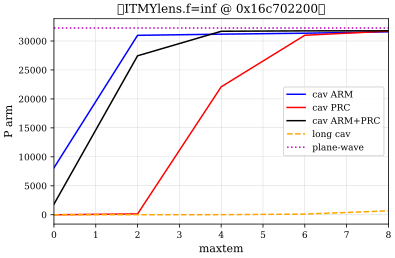

In [6]:
def run(model, orders):
    model.modes("off")
    plane_wave = model.run()
    homs = []
    for n in orders:
        model.modes("even", maxtem=n)
        with model.temporary_parameters():
            homs.append(model.run("""
                series(
                    maximize(Parm, [PRM.phi, ETMY.phi]),
                    noxaxis() # get detector outputs
                )
            """)['noxaxis'])
    return plane_wave, homs

orders = range(0, 10, 2)

_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
plane_wave, homs = run(_model, orders)

_model = model.deepcopy()
_model.parse("cav cavPRC PRM.p2.o via=ITMY.p1.i")
plane_wave2, homs2 = run(_model, orders)

_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
_model.parse("cav cavPRC PRM.p2.o via=ITMY.p1.i")
plane_wave3, homs3 = run(_model, orders)

_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o via=PRM.p2.i")
plane_wave4, homs4 = run(_model, orders)

plt.plot(orders, tuple(_['Parm'] for _ in homs), label='cav ARM')
plt.plot(orders, tuple(_['Parm'] for _ in homs2), label='cav PRC')
plt.plot(orders, tuple(_['Parm'] for _ in homs3), label='cav ARM+PRC')
plt.plot(orders, tuple(_['Parm'] for _ in homs4), label='long cav', ls='--')
plt.hlines(plane_wave['Parm'], 0, 8, ls=':', color='m', label='plane-wave')
plt.legend()
plt.xlabel("maxtem")
plt.ylabel("P arm")
plt.title(repr(model.ITMYlens.f));

This final plot shows us that depending on how we set the interferometer cavity eigenmodes, we need more or less orders to describe it. Ideally we do not want to have large mismatches in singular places, as that will require many orders to be required to converge. This best option in this case is defining both an arm and power-recycling cavity command. This may not be the case for your model, so it is always worth checking using a method like this.